Running unsupervised EM algorithm...
Converged after 145 iterations
with ll loss -1801.75

Running semi-supervised EM algorithm...
Converged after 25 iterations
with ll loss -1646.22

Running unsupervised EM algorithm...
Converged after 128 iterations
with ll loss -1801.82

Running semi-supervised EM algorithm...
Converged after 29 iterations
with ll loss -1646.22

Running unsupervised EM algorithm...
Converged after 123 iterations
with ll loss -1801.74

Running semi-supervised EM algorithm...
Converged after 22 iterations
with ll loss -1646.22



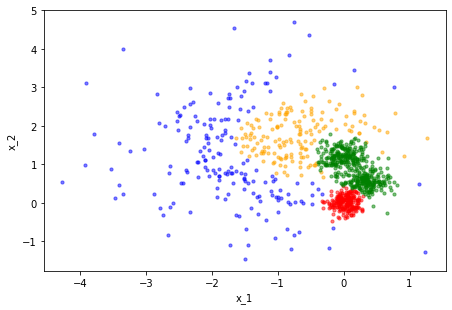

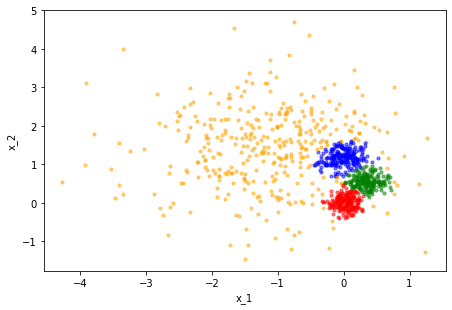

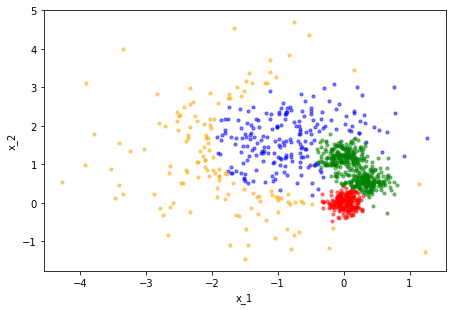

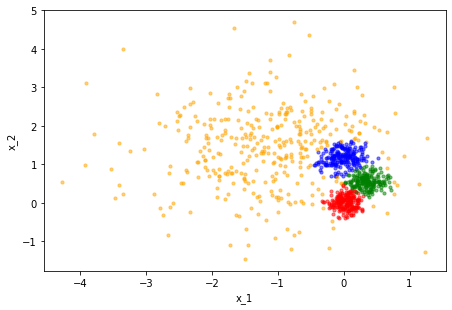

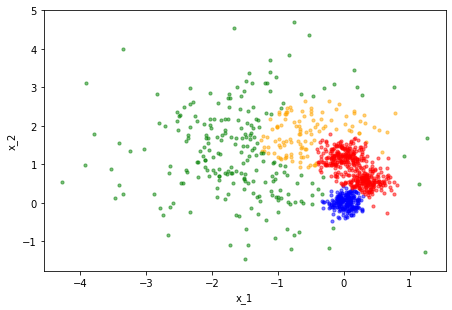

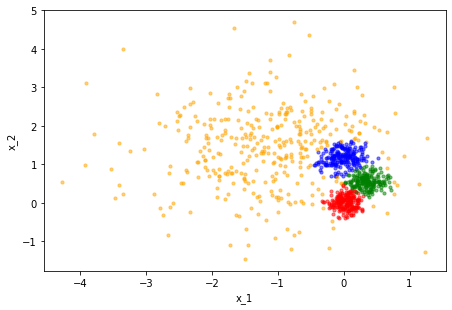

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import os


PLOT_COLORS = ['red', 'green', 'blue', 'orange']  # Colors for your plots
K = 4           # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run (can be adjusted for debugging)
UNLABELED = -1  # Cluster label for unlabeled data points (do not change)


def main(is_semi_supervised, trial_num):
    """Problem 3: EM for Gaussian Mixture Models (unsupervised and semi-supervised)"""
    print('Running {} EM algorithm...'
          .format('semi-supervised' if is_semi_supervised else 'unsupervised'))

    # Load dataset
    train_path = os.path.join('.', 'train.csv')
    x_all, z_all = load_gmm_dataset(train_path)

    # Split into labeled and unlabeled examples
    labeled_idxs = (z_all != UNLABELED).squeeze()
    x_tilde = x_all[labeled_idxs, :]   # Labeled examples
    z_tilde = z_all[labeled_idxs, :]   # Corresponding labels
    x = x_all[~labeled_idxs, :]        # Unlabeled examples

    # Initialize parameters phi, mu, sigma
    n_examples, dim = x_all.shape
    clustering = np.random.randint(K, size=n_examples)
    phi = np.ones(K) / K
    mu = np.empty([K, dim])
    sigma = np.empty([K, dim, dim])
    for j in range(K):
        x_j = x_all[clustering == j]
        mu[j] = np.mean(x_j, axis=0)
        sigma[j] = (x_j - mu[j]).T @ (x_j - mu[j]) / len(x_j)

    if is_semi_supervised:
        w = run_semi_supervised_em(x, x_tilde, z_tilde, phi, mu, sigma)
    else:
        w = run_em(x, phi, mu, sigma)
        
    # Plot your predictions
    z_pred = np.argmax(w, axis=1)
    plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)


def run_em(x, phi, mu, sigma):
    """Problem 3(d): EM Algorithm (unsupervised).

    See inline comments for instructions.

    Args:
        x: Design matrix of shape (n_examples, dim).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, of shape (k, dim).
        sigma: Initial cluster covariances, of shape (k, dim, dim).

    Returns:
        Updated weight matrix of shape (n_examples, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    eps = 1e-3    # Convergence threshold
    max_iter = 2000
    n_examples, dim = x.shape

    ll = prev_ll = np.inf
    log_prob = np.empty([n_examples, K])

    for i in range(max_iter):
        # E-step
        for j in range(K):
            exponents = np.sum((x - mu[j]) @ LA.inv(sigma[j]) * (x - mu[j]), axis=1)
            log_prob[:, j] = -0.5 * (np.log(LA.det(sigma[j])) + exponents) + np.log(phi[j])
        w = log_prob - logsumexp(log_prob).reshape(-1, 1)
        w = np.exp(w)
        
        # Check convergence
        # Stop when the absolute change in log-likelihood is < eps
        ll = - n_examples * dim / 2 * np.log(2 * np.pi) + np.sum(logsumexp(log_prob))
        if np.abs(ll - prev_ll) < eps:
            print(f'Converged after {i + 1} iterations\nwith ll loss {ll:.2f}\n')
            break
        prev_ll = ll
        
        # Do M-step
        phi = np.sum(w, axis=0) / n_examples
        for j in range(K):
            mu[j] = w[:,j] @ x / np.sum(w[:,j])
            sigma[j] = w[:,j] * (x - mu[j]).T @ (x - mu[j]) / np.sum(w[:,j])

    return w


def run_semi_supervised_em(x, x_tilde, z_tilde, phi, mu, sigma):
    """Problem 3(e): Semi-Supervised EM Algorithm.

    See inline comments for instructions.

    Args:
        x: Design matrix of unlabeled examples of shape (n_examples_unobs, dim).
        x_tilde: Design matrix of labeled examples of shape (n_examples_obs, dim).
        z_tilde: Array of labels of shape (n_examples_obs, 1).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, of shape (k, dim).
        sigma: Initial cluster covariances, of shape (k, dim, dim).

    Returns:
        Updated weight matrix of shape (n_examples, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    alpha = 20.                   # Weight for supervised objective
    eps = 1e-3                    # Convergence threshold
    max_iter = 2000
    n0, dim = x.shape             # for unobserved examples
    n1 = x_tilde.shape[0]         # for observed examples
    num_total = n0 + n1

    x = np.vstack([x, x_tilde])   # new x contains all examples
    w1 = alpha * (z_tilde == np.arange(K))    # weights for observed examples
    
    ll = prev_ll = - np.inf
    log_prob = np.empty([num_total, K])

    for it in range(max_iter):
        # Do E-step
        for j in range(K):
            exponents = np.sum((x - mu[j]) @ LA.inv(sigma[j]) * (x - mu[j]), axis=1)
            log_prob[:, j] = -0.5 * (np.log(LA.det(sigma[j])) + exponents) + np.log(phi[j])
        w = np.exp(log_prob - logsumexp(log_prob).reshape(-1, 1))
        w = log_prob - logsumexp(log_prob).reshape(-1, 1)
        w = np.exp(w)
        
        # Check convergence
        # Stop when the absolute change in log-likelihood is < eps
        ll = (- num_total * dim / 2 * np.log(2 * np.pi) 
              + np.sum(logsumexp(log_prob[:-n1]))
              + np.sum(w1 * log_prob[-n1:]))
        if np.abs(ll - prev_ll) < eps:
            print(f'Converged after {it + 1} iterations\nwith ll loss {ll:.2f}\n')
            break
        prev_ll = ll
        w[-n1:] = w1
        
        # Do M-step
        phi = np.sum(w, axis=0) / (n0 + alpha * n1)
        for j in range(K):
            mu[j] = w[:, j] @ x / np.sum(w[:, j])
            sigma[j] = w[:, j] * (x - mu[j]).T @ (x - mu[j]) / np.sum(w[:, j])

    return w


def logsumexp(z):
    """Compute the logsumexp function for each row of z."""
    z_max = np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z - z_max)
    sum_exp_z = np.sum(exp_z, axis=1)
    return z_max.squeeze() + np.log(sum_exp_z)


def plot_gmm_preds(x, z, with_supervision, plot_id):
    """Plot GMM predictions on a 2D dataset `x` with labels `z`.

    Write to the output directory, including `plot_id`
    in the name, and appending 'ss' if the GMM had supervision.

    NOTE: You do not need to edit this function.
    """
    plt.figure(figsize=(7.2, 4.8))
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.5
        plt.scatter(x_1, x_2, marker='.', s=40, c=color, alpha=alpha)
        
    if with_supervision:
        file_name = f'semisup_gmm{plot_id}.png'
    else:
        file_name = f'unsup_gmm{plot_id}.png'
    save_path = os.path.join('.', file_name)
    plt.savefig(save_path)


def load_gmm_dataset(csv_path):
    """Load dataset for Gaussian Mixture Model.

    Args:
         csv_path: Path to CSV file containing dataset.

    Returns:
        x: NumPy array shape (n_examples, dim)
        z: NumPy array shape (n_exampls, 1)

    NOTE: You do not need to edit this function.
    """

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    z_cols = [i for i in range(len(headers)) if headers[i] == 'z']

    x = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols, dtype=float)
    z = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=z_cols, dtype=float)

    if z.ndim == 1:
        z = np.expand_dims(z, axis=-1)

    return x, z


if __name__ == '__main__':
    np.random.seed(150)
    # Run NUM_TRIALS trials to see how different initializations
    # affect the final predictions with and without supervision
    for t in range(NUM_TRIALS):
        main(is_semi_supervised=False, trial_num=t)
        main(is_semi_supervised=True, trial_num=t)